# Using Apache Arrow Flight with Trovares xGT

The outline of this notebook:

1. Generate a table of edges with random data.
1. Bring edge table into an Arrow format.
1. Send Arrow Flight to Trovares xGT.
1. Request to run a graph query on xGT.
1. Bring results back as an Arrow Flight.
1. Visualize results.

## Generate edges with random data.

First, set up parameters for edge table.

The table will have four columns.
The first two columns representing *source* and *target* of each edge.
The other two columns representing edge attributes.

The values of the first two columns are drawn randomly in the range of `1` to `NUM_NODES`.

In [1]:
# Metadata of random data table
NUM_ROWS=100
NUM_NODES=10

In [2]:
# Generate table
import pandas as pd
import random
random.seed()
alpha='abcdefghijklmnopqrstuvwxyz'

data = {
    'source': [random.randint(1, NUM_NODES) for _ in range(NUM_ROWS)],
    'target': [random.randint(1, NUM_NODES) for _ in range(NUM_ROWS)],
    'attr1' : [random.choice(alpha) for _ in range(NUM_ROWS)],
    'attr2' : [random.choice(alpha) for _ in range(NUM_ROWS)],
}
df = pd.DataFrame(data)

## Bring edge table into Arrow format.

In [3]:
import pyarrow as pa
import pyarrow.flight

arrow_edges = pa.Table.from_pandas(df)
arrow_edges

pyarrow.Table
source: int64
target: int64
attr1: string
attr2: string
----
source: [[6,6,9,2,4,...,7,3,8,9,10]]
target: [[7,1,10,6,9,...,7,7,6,4,3]]
attr1: [["x","u","u","r","k",...,"p","x","m","q","g"]]
attr2: [["a","u","j","f","d",...,"m","g","p","g","x"]]

In [4]:
arrow_edges.column_names

['source', 'target', 'attr1', 'attr2']

## Send Arrow Flight to Trovares xGT.

First create frames on xGT to hold the graph data.

Then establish a PyArrow Flight connection to the xGT server and send the data.

In [5]:
import xgt
server = xgt.Connection()
server.set_default_namespace('arrow')

server.create_edge_frame_from_data(arrow_edges, "Edge",
                                   source="Node", target="Node",
                                   source_key="source", target_key="target")

## Request to run a graph query on xGT.

In [6]:
query = """
MATCH (a)-[e1:Edge]->(b)-[e2:Edge]->(c)
WHERE a <> b and b <> c and a <> c
  AND e1.attr1 = e2.attr1
RETURN DISTINCT a.id AS a, c.id AS c, e1.attr1 AS attr1
INTO answer_set
"""

job = server.run_job(query)
data = job.get_data_pandas()
data

## Bring results back

Note that this process uses the *Arrow Flight* mechanism to transfer the `answer_set` data from the xGT server to the client.

In [7]:
answers = server.get_table_frame("answer_set").get_data_arrow()
answers

pyarrow.Table
a: int64
c: int64
attr1: string
----
a: [[10,6,5,1,2,...,4,6,1,9,4]]
c: [[7,3,3,10,3,...,3,5,6,4,6]]
attr1: [["t","q","p","u","l",...,"q","o","r","p","q"]]

## Visualize results.

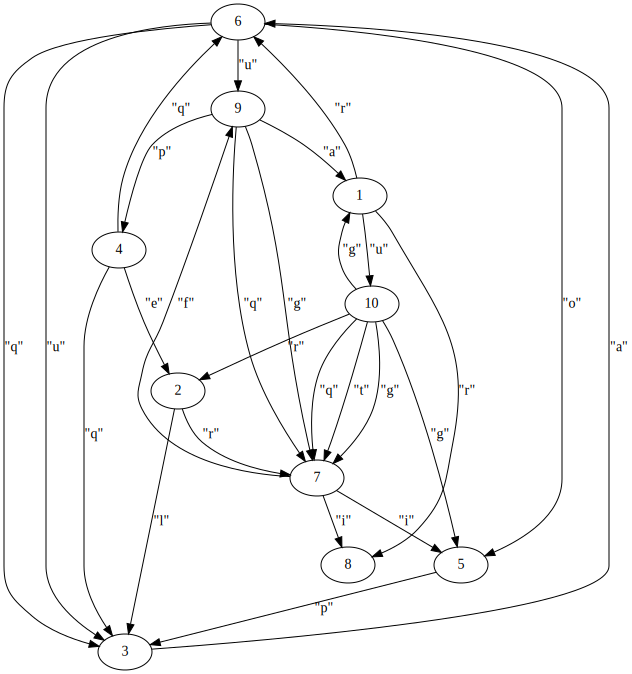

In [8]:
#answers_table = pa.Table.from_pandas(answers)
try:
    import graphviz
    from IPython.display import Image
    
    gr = graphviz.Digraph()
    # Draw nodes for the union of all source and target nodes in the two paths
    for node in set(answers.column('a')) | set(answers.column('c')):
        gr.node(str(node))
    # Draw edges for each returned edge
    for batch in answers.to_batches():
        d = batch.to_pydict()
        for a, c, attr1 in zip(d['a'], d['c'], d['attr1']):
            # Do something with the row
            gr.edge(str(a), str(c), label=f'"{str(attr1)}"')

except ImportError:
    print("You must install graphviz in order to vizualize the results as a graph")
    print("\n!python3 -m pip install graphviz")
    gr = None

gr